# Review inputs

This notebook checks the setup for each of the games in the experiment, 
to make sure that the social network, clues, and clue assignments reflect
the desired experimental condition.


In [1]:
%pylab inline
import networkx as nx
import json
import numpy as np
import pandas as pd
from collections import Counter

import language_check
import re
import string
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


## Import and describe Experiment

In [2]:
experiment_filepath = "games/exp_design6_matched_20200224_122320.json"
#experiment_filepath = "games/exp_design4_matched_20190925_121500.json"  # keynote
#experiment_filepath = "games/exp_design4_matched_20190924_155256.json"

with open(experiment_filepath, 'r') as f:
    experiment = json.load(f)
    
describe = {k: experiment[k] for k in set(experiment.keys())-{"games"}}
describe['n_games'] = len(experiment["games"])
describe


{'deg': 3,
 'n_players': 20,
 'n_beliefs': 4,
 'p_broken_list': 'matched inter/indep pair',
 'replications': 40,
 'experiment_setup_name': 'exp_design6_matched_20200224_122320',
 'n_games': 80}

In [14]:
for game_id, game in experiment['games'].items():
    print(game_id)

panel_0_matched_pair_exp_design6_matched_20200224_122320
panel_0_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_1_matched_pair_exp_design6_matched_20200224_122320
panel_1_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_2_matched_pair_exp_design6_matched_20200224_122320
panel_2_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_3_matched_pair_exp_design6_matched_20200224_122320
panel_3_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_4_matched_pair_exp_design6_matched_20200224_122320
panel_4_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_5_matched_pair_exp_design6_matched_20200224_122320
panel_5_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_6_matched_pair_exp_design6_matched_20200224_122320
panel_6_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_7_matched_pair_exp_design6_matched_20200224_122320
panel_7_matched_pair_caveman_exp_design6_matched_20200224_122320
panel_8_matched_pair_exp

## check network structure


In [3]:
for game_id, game in experiment['games'].items():
    g = nx.from_dict_of_lists(game['neighbors'])
    #nx.draw_networkx(g)
    
    # check that each panel has two components
    assert(nx.number_connected_components(g)==2)
    
    # check that each component has nodes of the same names
    c1, c2 = [g.subgraph(c) for c in nx.connected_components(g)]
    assert(set([n[1:] for n in c1.nodes()]) == set([n[1:] for n in c2.nodes()]))
    
    # check that each component has the right number of nodes
    assert(nx.number_of_nodes(c1)==describe['n_players'])
    assert(nx.number_of_nodes(c2)==describe['n_players'])
        
    # check that each node in each component has matching neighbors
    for n in c1:
        n2 = 't'+n[1:] if n[0] == 'c' else 'c'+n[1:]
        assert(set([nb[1:] for nb in c1.neighbors(n)]) == set([nb[1:] for nb in c2.neighbors(n2)]))

    # check that each node has the number of neighbors listed in the game heading
    assert(all([v== describe['deg'] for k, v in g.degree()]))
    
print('pass')

pass


'panel_0_matched_pair_exp_design6_matched_20200224_122320'

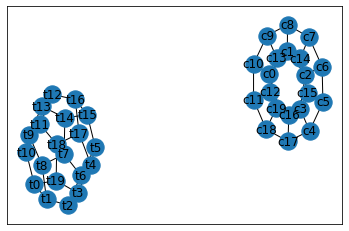

In [25]:
game_id = list(experiment['games'].keys())[0]
game = experiment['games'][game_id]
g = nx.from_dict_of_lists(game['neighbors'])
nx.draw_networkx(g)
game_id

'panel_0_matched_pair_caveman_exp_design6_matched_20200224_122320'

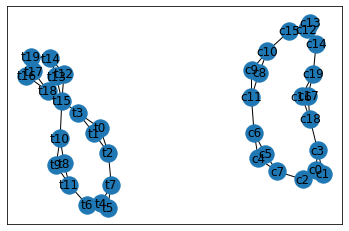

In [26]:
game_id = list(experiment['games'].keys())[1]
game = experiment['games'][game_id]
g = nx.from_dict_of_lists(game['neighbors'])
nx.draw_networkx(g)
game_id

## check clue structure

In [4]:
tool = language_check.LanguageTool('en-US')
err_counter = Counter()
err_examples = {}

for game_id, game in experiment['games'].items():
    
    for clue_id, clue in game['clues'].items():
        # check that each clue is well formatted        
        assert(len(clue['nodes'])==2)
        assert(all([len(re.sub(r"\s+", "", node, flags=re.UNICODE))>=2  # remove whitespace
                    for node in clue['nodes']]))  # each node has at least two non-whitespace chars
        assert(all([re.sub(r'\{.*\}', '', node.lower()) in clue['content'].lower()  # allow template nodes
                    for node in clue['nodes']]))  # each node present in clue string
        assert(clue['content'].endswith('.'))
        assert(clue['content'][0].isupper())
        
        # check for language errors
        errs = tool.check(clue['content'])
        if(errs):
            for err in errs:
                key = err.locqualityissuetype + ': "' + err.context[err.contextoffset:err.contextoffset+err.errorlength] +'"'
                err_counter[key]+=1
                err_examples[key] = err.context
        
    # check that clues connected to the stolen object or crime scene are identical between trmt and ctrl
    for clue_id, clue in game['clues'].items():
        if (clue_id.startswith('t') and 
            ('_1_' in clue_id or '_2_' in clue_id)):
            control_clue = game['clues']['c'+clue_id.lstrip('t')]
            assert clue['content'] == control_clue['content']

    # check that clue graph is complete for treatment case
    cgt = nx.from_edgelist([
        clue['nodes'] for clue_id, clue in game['clues'].items() if clue_id.startswith('t')
    ])
    assert(all([v == cgt.number_of_nodes()-1 for k, v in cgt.degree()]))

    # check that clue graph has correct degree distribution for control case
    cgc = nx.from_edgelist([
        clue['nodes'] for clue_id, clue in game['clues'].items() if clue_id.startswith('c')
    ])
    assert(Counter([v for k, v in cgc.degree()]) == {12:2, 7:11, 1:55})
    #if not Counter([v for k, v in cgc.degree()]) == {12:2, 7:11, 1:55}:
    #    print([(k,v) for k, v in cgc.degree() if v not in [12, 7, 1]], '\n')
    
print('pass')
    
for key, count in err_counter.most_common():
    print(count, key, err_examples[key])

pass
418 misspelling: "Bennet" Bennet had been seen at a funeral.
304 misspelling: "grey-haired" A grey-haired man had been seen at a delicatessen.
288 misspelling: "Asper" ...A yellow box truck was seen leaving the Asper Casino.
288 misspelling: "Daly" A black Hummer was seen leaving the Daly Auction House.
240 misspelling: "Kensington" A white Ford Fusion was seen leaving Kensington House.
240 misspelling: "Dalhoff" A flatbed trailer was seen leaving the Dalhoff Estate.
228 misspelling: "Yaris" A blue Toyota Yaris was ticketed for failing to yield.
228 misspelling: "Jetta" A silver VW Jetta had been seen driving through town.
144 misspelling: "Danforth" ... blue Toyota Yaris was seen leaving the Danforth Hotel.
96 misspelling: "Darrowby" ...A yellow box truck was seen leaving the Darrowby Country Club.
48 misspelling: "Kentwood" A silver VW Jetta was seen leaving the Kentwood Mansion.
28 grammar: "an impound" A white Toyota Avalon was found at an impound lot.
28 misspelling: "café" H

## manually spot check a single game's clues

In [5]:
game = experiment['games'][np.random.choice(list(experiment['games'].keys()))] # choose a random game
for clue_id, clue in game['clues'].items():
    if clue_id.startswith('t'):
        control_clue = game['clues']['c'+clue_id.lstrip('t')]
        if '_1_' in clue_id or '_2_' in clue_id:
            print(clue['content'].center(110))
        else:
            print(clue['content'].rjust(55), '|', control_clue['content'])

                             The painting was kept in a case at Kensington House.                             
                                    Sullivan was seen at Kensington House.                                    
                                     Wagner was seen at Kensington House.                                     
                                     Bennet was seen at Kensington House.                                     
                          A person wearing a tracksuit was seen at Kensington House.                          
                          A person wearing a wool hat was seen at Kensington House.                           
                               A pot-bellied man was seen at Kensington House.                                
                                 A handsome man was seen at Kensington House.                                 
                     Evidence at Kensington House indicates the use of a serrated knife.                      
 

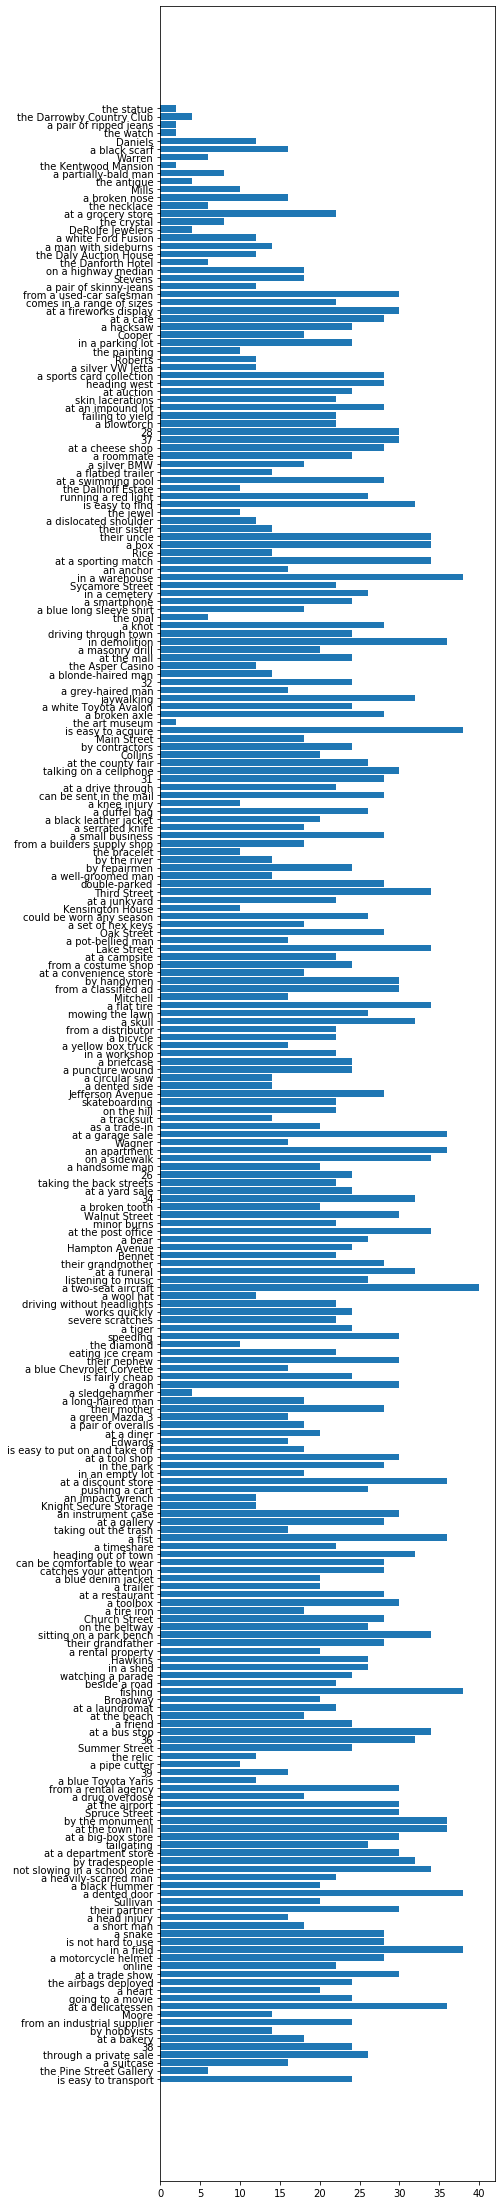

In [6]:
# check the ensemble of games to make sure that no particular clue elements have undue weight
element_counter = Counter()
for game_id, game in experiment['games'].items():
    nodes = set()
    for clue_id, clue in game['clues'].items():
        for node in clue['nodes']:
            nodes.add(node)
    for node in nodes:
        element_counter[node] += 1
            
plt.figure(figsize=(6,40))
plt.barh(range(len(element_counter)), element_counter.values())
plt.yticks(range(len(element_counter)), element_counter.keys()); 

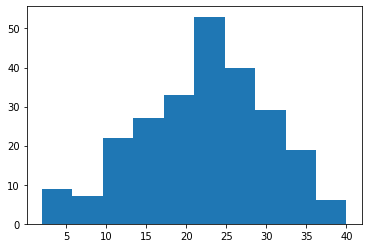

In [8]:
plt.hist(element_counter.values());

## check clue/belief assignments

In [9]:
for game_id, game in experiment['games'].items():
    belief_list = pd.Series([bf for n in game['beliefs'] for bf in game['beliefs'][n]])
    belief_counts = belief_list.value_counts()
    
    # check that each belief shows up exactly once, apart from clue_1_2, which is present 3 times
    assert(belief_counts['cclue_1_2'] == 3)
    assert(belief_counts['tclue_1_2'] == 3)
    assert(all([v==1 for b, v in belief_counts.iteritems() if b not in ['cclue_1_2', 'tclue_1_2']]))
    
    # check that each player has 4 beliefs
    assert(all([len(v)==4 for k,v in game['beliefs'].items()]))

    # check that control positions have beliefs that match their corresponding treatment positions
    for pos, bs in game['beliefs'].items():
        if pos.startswith('t'):
            control_bs = game['beliefs']['c'+pos.lstrip('t')]
            assert set([b[1:] for b in bs]) == set([cb[1:] for cb in control_bs])

print('pass')
    

pass


## visually spot-check the relationships between clues

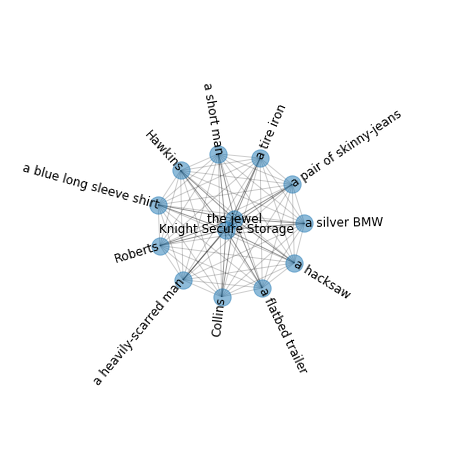

In [10]:
random_game_id = np.random.choice(list(experiment['games'].keys()))
game = experiment['games'][random_game_id]
#plt.figure(figsize=(10,10))
cg = nx.from_edgelist([n['nodes'] for cid, n in game['clues'].items() if cid[0]=='t'])  # clue graph
center_nodes = [game['nodes']['CrimeScene_1'], game['nodes']['StolenObject_1']]
center = nx.from_edgelist(cg.edges(center_nodes))
cg.remove_edges_from(center.edges())
cg.remove_nodes_from(center_nodes)

pos = nx.spring_layout(center)

theta = {key: np.arctan2(val[1], val[0]) * 180/np.pi if key not in center_nodes else 0 
         for key, val in pos.items() }

plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(center, pos=pos, alpha=.5)
labels = nx.draw_networkx_labels(center, pos=pos, font_size=12, ha='left')

for key,t in labels.items():
    if key not in center_nodes:
        if 90 < theta[key] or theta[key] < -90 :
            angle = 180 + theta[key]
            t.set_ha('right')
        else:
            angle = theta[key]
            t.set_ha('left')
        t.set_va('center')
        t.set_rotation(angle)
        t.set_rotation_mode('anchor')
nx.draw_networkx_edges(cg, pos=pos, alpha=.2)
nx.draw_networkx_edges(center, pos=pos, alpha=.4)
plt.box(False)
a=3
plt.xlim(-a,a)
plt.ylim(-a,a)

# save locations with clues for later
clue_pos = {}
for i, n in game['clues'].items():
    if i[0] == 't':
        clue_pos[i[1:]] = np.array([pos[n['nodes'][0]], pos[n['nodes'][1]]])
    
centroids = {k: np.mean(v, axis=0) for k, v in clue_pos.items()}
lengths = {k: sqrt(np.sum((v[1]-v[0])**2)) for k, v in clue_pos.items()}

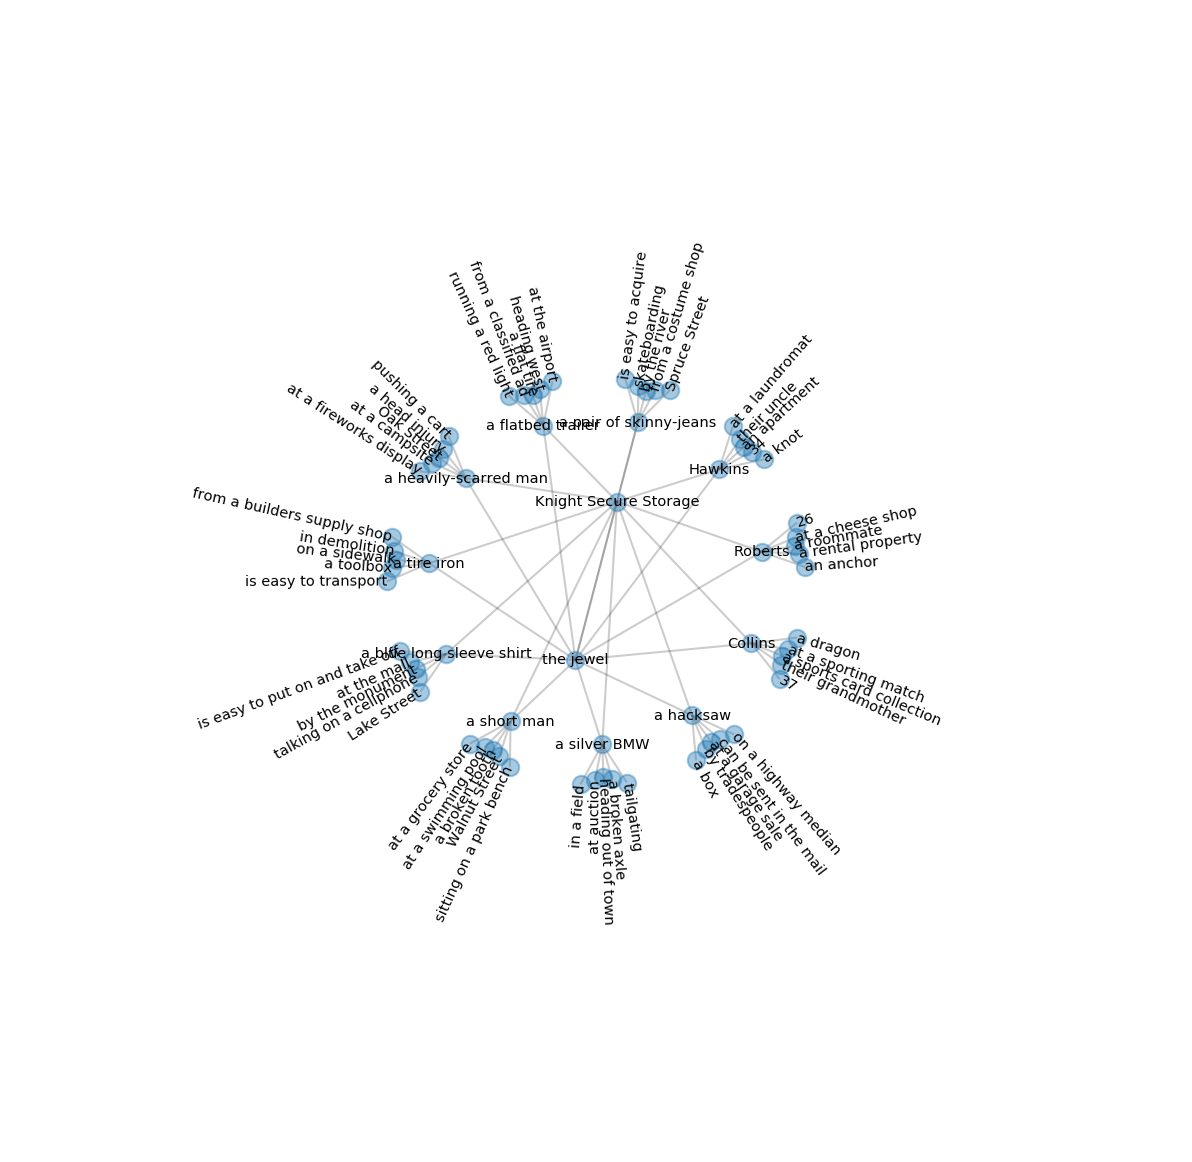

In [11]:
ccg = nx.from_edgelist([n['nodes'] for cid, n in game['clues'].items() if cid[0]=='c'])  # control clue graph

# group by shell
center_nodes = [game['nodes']['CrimeScene_1'], game['nodes']['StolenObject_1']]
center = nx.from_edgelist(ccg.edges(center_nodes))
shell_1_nodes = list(set(center.nodes()) - set(center_nodes))
shell_2_nodes = [nb for n in shell_1_nodes for nb in ccg.neighbors(n) if nb not in center_nodes]

rot_n = 2  # rotate n (helps align the outer shell with the middle shell)
shell_2_nodes = shell_2_nodes[rot_n:] + shell_2_nodes[:rot_n]

# positions for nodes
pos = nx.shell_layout(ccg, [center_nodes, shell_1_nodes, shell_2_nodes], scale=1.3)
pos = nx.spring_layout(ccg, pos=pos, fixed=center_nodes+shell_1_nodes, 
                       iterations=1, k=1/sqrt(70))

def rotate(x, rotation=0):
    length = sqrt(x[0]**2 + x[1]**2)
    angle = np.arctan2(x[0], x[1])
    new_angle = angle+rotation
    return [length*cos(new_angle), length*sin(new_angle)]
pos = {k:rotate(v, -0.25) for k, v in pos.items()}

theta = {key: np.arctan2(val[1], val[0]) * 180/np.pi if key in shell_2_nodes else 0 
         for key, val in pos.items() }

plt.figure(figsize=(10,10), dpi=150)
nx.draw_networkx_nodes(ccg, pos=pos, alpha=.4, node_size=70)
nx.draw_networkx_edges(ccg, pos=pos, alpha=.2)

labels = nx.draw_networkx_labels(ccg, pos=pos, font_size=7, ha='left')

for key,t in labels.items():
    if key in shell_2_nodes:
        if 90 < theta[key] or theta[key] < -90 :
            angle = 180 + theta[key]
            t.set_ha('right')
        else:
            angle = theta[key]
            t.set_ha('left')
        t.set_va('center')
        t.set_rotation(angle)
        t.set_rotation_mode('anchor')


plt.box(False)
a=3
plt.xlim(-a,a)
plt.ylim(-a,a);

# stats

In [12]:
all_clues = [cl['content'] for _, game in experiment['games'].items() for _, cl in game['clues'].items()]
clue_counts = pd.value_counts(all_clues)
print("There are a total of %i unique clues in the experiment" % len(clue_counts))

There are a total of 3250 unique clues in the experiment


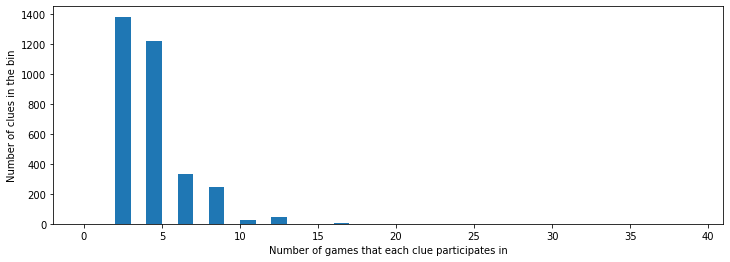

In [13]:
plt.figure(figsize=(12,4))
plt.hist(clue_counts.values, bins=range(describe['replications']))
plt.xlabel('Number of games that each clue participates in')
plt.ylabel('Number of clues in the bin');